# Welcome to the FLAME GPU Sugarscape Tutorial

This is a tutorial for FLAME GPU. An open-source piece of software for the simulation of complex systems. It is domain-independent and can be used for any simulation that uses the idea of agent-based modelling. The agent-based modelling approach of describing individual behaviours and observing the emergent outputs enables FLAME GPU to be used for a wide range of examples such as flocking, cellular biology, and transportation. This tutorial focuses on the classical Sugascape model.

The purpose of the tutorial is to introduce the software and the modelling abstraction (API). The software aims to hide the underlying complexities of the GPU such as data structures and even parallelism. That said their are important considerations when moving from a serial modelling methodology to a parallel one which are presented and explained during this exercise.

FLAME GPU is developed in C++ but has a Python front end. This tutorial uses Python to define both the model description and the agent functions. There is an extensive set of user guidens and code documentation availabel for FLAME GPU which you can use alongside this tutorial for help: [https://docs.flamegpu.com/](https://docs.flamegpu.com/)

![Sugarscape visualisation](./images/pyfgpu2_icon_256.png)

## Background Information on Jupyter

For the purpose of this tutorial, the Jupyter notebook has been configured to work with FLAME GPU 2. The Jupyter notebook is a web based environment for interactive computing. It is capable of running code in a wide variety of programming languages. The notebook consists of cells which can be of type code or markdown (by default, new cells are created as code cells). You can execute the content of code cells by clicking the Run button. Cells which are actively running code will show a '*' symbol (or 'Play' icon in Colab) and cells which have completed will show a number indicating the position in which the cell was execute (or a green tick in Colab).

The notebook will guide you through the various commands required to run and edit a FLAME GPU 2 model using the python interface.

### Before Beginning

If using Google Colab, please ensure you have this notebook enabled with GPU before running (Runtime->Change runtime type). If you are not using Google Colab you can ignore this instruction.

### Running your first code cell

The cell below is a simple example of a code cell. Clicking on the play button which appears when hovering over the cell with the mouse will run the code and you should see "Hello!" displayed beneath the code cell.

### Running on Windows

There are some known limitations when running on Windows. E.g. Any errors during compilation of agent functions will be directed to the console which launched the Jupyter notebook rather than displayed in the notebook itself. See 'release notes' in the tutorial [README.md](README.md).  

In [1]:
print("Hello!")

Hello!


# Installation and Importing of FLAME GPU

The FLAME GPU python library can be installed through pip. This installs a binary release of the FLAME GPU 2 library. Run the cell below to install the FLAME GPU 2 library. If you are on a system where this has been pre-installed then the library will simply be imported.

In [2]:
# check if pyflamegpu is installed and if not install it
import importlib.util
if importlib.util.find_spec('pyflamegpu') is None:
    import sys
    !{sys.executable} -m pip install --extra-index-url https://whl.flamegpu.com/whl/cuda120/ pyflamegpu==2.0.0rc2 # type: ignore

# Import pyflamegpu and some other libraries we will use in the tutorial
import pyflamegpu
import pyflamegpu.codegen
import sys, random, math
import matplotlib.pyplot as plt
import importlib

#set matplotlib backend to widget for some advanced plotting tools
%matplotlib widget 

# import 
import sugarscape_common
import movement_submodel
import sugarscape_visualiser

# reload local modules
importlib.reload(sugarscape_common)
importlib.reload(movement_submodel)
importlib.reload(sugarscape_visualiser)

<module 'sugarscape_visualiser' from 'D:\\Code\\pyflamegpu-tutorial\\sugarscape_visualiser.py'>

With the library installed, we need to configure the CUDA_PATH environment variable so the library can find the CUDA installation (Linux only as CUDA_PATH) will already be configured in Windows.

In [3]:
import platform
if platform.system() == 'Linux':
    %env CUDA_PATH=/usr/local/cuda

# The Sugarscape model

## Model Description

The Sugarscape model is a classical agent based model where agents compete for resources within a grid world. It was first proposed by Epstein and Axtell in their book 'Growing Artifical Societies'. The variant of the model that we will work with in this tutorial is equivalent to the model described in chapter 2 which is the same as the 'Sugarscape 2 constant growback' model within NetLogo. It is also used as a benchmark example in the paper 'FLAME GPU 2: Flexible Large Scale Agent Based Simulation on GPUs'.

Within this model, $N$ Sugarscape agents occupy a 2D grid environment of `cells`. Each cell contains a level of sugar $s$ which has a maximum value of $W_{max}$. The grid wraps so as to form a torus shaped environment without boundaries. At each time-step sugar grows back within a cell at a rate of $\alpha$. Agents have a fixed vision distance of $V$ cells in the north, south, east and west directions as well as a sugar wealth, $w$, which represents a quantity of obtained sugar. Within this tutorial all agents have a fixed vision $V=1$. 

The Sugarscape model is an interesting choice to learn FLAME GPU as it introduces a form of 'conflict' which is not present within the serial version. E.g. 
Within the serial implementation of this model, at each time-step the order of agents is randomised so that sequentially, each agent can choose to move to a new empty cell, with a preference for cells where there is a higher quantity of sugar available than their current location. If there are multiple potential cells which an agent could move to, then one is chosen from the candidate cells at random. Upon moving to a new cell, or if an agent remains stationary, the agent consumes all of the sugar at the agent's current location and decreases its own sugar wealth by a metabolism $m$ . If at this stage the agents sugar wealth is not greater than zero it dies and is removed from the simulation. 

![Sugarscape visualisation](./images/sugarscape_visualisation_0.png)

## Model Implementation within FLAME GPU

Within this tutorial we will consider both Sugarscape agents and empty environment cells as agents. This makes modelling sense, as empty cells within the environment have their own behaviour in the form of sugar growback. Each aspect of the model implementation will be explained as we progress through the tutorial. 

# Model Parameters

Before defining the model in FLAME GPU we will first define some parameters of the model in Python. Additionally we will define some parameters which will be used later to configure distributions used when generating the initial state of the agent population.

In [4]:
# Model parameters
S_MAX = 4              # S_{max}, env sugar maximum level
S_ALPHA = 1            # /alpha, sugar growback rate

# Parameters for initialisation of the model (see `Creation of Initial Population Data`)
H_MIN = 20             # H_{min}, hotspot minimum distance
W_MIN = 5              # W_{min}, agent wealth minimum
W_MAX = 25             # W_{max}, agent welath maximum
M_MIN = 1              # M_{min}, agent metabolism minimum
M_MAX = 4              # M_{max}, agent metabolism maximum
P_OCCUPATION = 0.17    # /rho, probability of sugarscape agent occupation

SIMULATION_STEPS = 100 # number of simulation steps

*Note: Some additional parameters and values are defined in [sugarscape_common.py](sugarscape_common.py). These include the environment width and height and some constants used to define status of an agent. I.e. 'unoccupied', 'occupied'.*

# Creating a model

A FLAME GPU 2 model consists of: 

1. An environment which holds global information related to the simulation such as constant variables.
2. A description of any messages which represent information to communicated between agents.
3. A description of agents which includes any state variables that they have and any functions which they can execute.
4. A control flow which describes the execution order of any functions within a single iteration of the simulation.
5. Initial population data and a simulation object which is used to instantiated to simulation object. 

In the python build of FLAME GPU 2, all of these model elements are described through the python interface. A `ModelDescription` object acts as a parent/container for the various other components which make up the model. The following sections will describe how to create each of the above components and attach them to the `ModelDescription`. Each code cell defines a particular function. By defining functions rather than running the code directly, they can be updated individually and defined out of order. These functions are then all called in the correct order later in the tutorial.

The cell below creates and returns a `ModelDescription` object for the sugarscape model.

In [5]:
def create_model():
    model = pyflamegpu.ModelDescription("sugarscape")
    return model

# Defining the Environment

Within FLAME GPU the environment provides a mechanism to provide properties (variables) which can be accessed by all agents within a simulation. We previously defined a number of model parameters which will be used as initial values to environment properties in the cell below. It is important to define these as environment variables as Python global will not be available to agent functions which ultimately will be executed on the GPU device.

The cell below defines 4 different values for the agent status. Occupied and unoccupied are obvious in their meaning. The movement requested and movement unresolved status is used within the movement submodel and is explained later in the tutorial. 

In [6]:
def define_environment(model):
    env = model.Environment()
    env.newPropertyInt("sugar_growback_rate", S_ALPHA)
    env.newPropertyInt("sugar_max_capacity", S_MAX)
    
    # agent status
    env.newPropertyInt("agent_status_unoccupied", sugarscape_common.AGENT_STATUS_UNOCCUPIED)
    env.newPropertyInt("agent_status_occupied", sugarscape_common.AGENT_STATUS_OCCUPIED)
    env.newPropertyInt("agent_status_movement_requested", sugarscape_common.AGENT_STATUS_MOVEMENT_REQUESTED)
    env.newPropertyInt("agent_status_movement_unresolved", sugarscape_common.AGENT_STATUS_MOVEMENT_UNRESOLVED)

*Note: Although a default value for each property is set above, there are a number of ways that this can be overridden when creating the simulation object later. This can be useful if instantiating multiple simulations with differing environment properties.* 

# Defining the Agents

A FLAME GPU model can consist of any number of agents. Our Sugarscape model requires only a single agent type that will represent a single cell of the Sugarscape model it. It therefore requires an `x` and `y` position (identifying the position within a regular 2D lattice) and variables that hold information about both Sugarscape agents and the environment cell itself.

The agent definition below creates three agent functions (`metabolise`, `growback` and `move`). The `newRTCFunction` method is used to specify these alongside the `pyflamegpu.codegen` module which which has a `translate` function. The `translate` function will take a pure python agent function (the format of which is described later) and transpile (the process of converting source code from one programming language to another) it to C++. The `newRTCFunction` call indicates that it is a **R**un**T**ime **C**ompilation function which will ensure the C++ source is compiled during model initialisation. This translation from Python to C++ for compilation is a requirement of FLAME GPU which uses NVIDIA CUDA to program the GPU device. All agent functions are compiled with a FLAME GPU device API which provides the mechanisms to query agent variables, messages and the environment. If you wish to see the transpiled C++ then you can `print` the output of the `translate` function and inspect this yourself. It has a very close resemblance to the underlying Python.

*Note: The definition of an agent does not actually require any specialisation in terms of what type of spatial domain an agent lives within. Agents may may exist within regular grid (as is the case of the Sugarscape model), points within continuous space, a network, or any other domain abstraction. Rather than specialisation of agents, messages are instead specialised as a mechanism for agents to communicate within specific spatial constructs. The `x` and `y` variables exist so that the agent can communicate using the `Array2D` message specialism.*

The model variables are mapped to agent variables as follows;

| Model Variable | Agent Variable Name | Description
| :--- | :--- | :--- |
| $s$ | `env_sugar_level` | Environment sugar level |
| $m$ | `metabolism` | Metabolism |
| $w$ | `sugar_level` | Sugar Wealth |
|  | `env_sugar_max` | Each cell has a maximum sugar level which can be no greater than $S_{max}$

In [7]:
def define_agents(model):
    agent = model.newAgent("agent")
    
    # Generic variables
    agent.newVariableInt("x")
    agent.newVariableInt("y")
    agent.newVariableInt("agent_id")
    agent.newVariableInt("status")
    # Sugarscape agent specific variables
    agent.newVariableInt("sugar_level")
    agent.newVariableInt("metabolism")
    # Environment cell specific variables
    agent.newVariableInt("env_sugar_level")
    agent.newVariableInt("env_max_sugar_level")

    # Metabolise, growback and move functions
    metabolise_fn = agent.newRTCFunction("metabolise", pyflamegpu.codegen.translate(metabolise))
    growback_fn = agent.newRTCFunction("growback", pyflamegpu.codegen.translate(growback))
    move_fn = agent.newRTCFunction("move", pyflamegpu.codegen.translate(move))

    

# Specifying the Functional Dependencies

A FLAME GPU simulation consists of the execution of a set of simulation steps. Each step has represents a single iteration of the simulation and is made up of a set of agent functions that are executed. The order of function execution creates a directed graph where functions depend on one another either;

1. Directly i.e. function 'B' has a dependency on function 'A' if it expects function 'A' to have executed first, or
2. Indirectly i.e. function 'B' has a dependency on function 'A' if function b reads a message which function A will output.

We have not specified any messages yet within our model but we can specify that our functions have a set of direct dependencies. This can be done either explicitly, by specifying the layers ([see docs](https://docs.flamegpu.com/guide/defining-execution-order/layers.html)) on which function will execute or by specifying the actual dependencies ([see docs](https://docs.flamegpu.com/guide/defining-execution-order/dependency-graph.html)). The later is preferable as greater care must be taken in the specification of layers to ensure that dependencies are respected.

The cell below defines a function to specify the functional dependencies. It also adds an execution root, which can be an agent function or in this case a submodel (described later) which is used to provide conflict free movement of the agents. The call to the `generateLayers` function freezes the dependencies and generates a graph of execution layers which respects the dependencies.

In [8]:
def define_dependencies(model, movement_submodel):
    """
    Control Flow
    """
    agent = model.Agent("agent")
    move_fn = agent.Function("move")
    growback_fn = agent.Function("growback")
    metabolise_fn = agent.Function("metabolise")

    # specify the dependencies
    model.addExecutionRoot(movement_submodel)
    move_fn.dependsOn(growback_fn)
    growback_fn.dependsOn(metabolise_fn)
    metabolise_fn.dependsOn(movement_submodel)
    model.generateLayers()
    

# Defining Agent Functions

The Python agent functions referred to in our definition of the agent can now be specified. A limited subset of Python is supported which is restricted to Python features that can be easily transpiled to a C++ equivalent at runtime for compilation. For example Python functionality like generator expressions, arrays, dictionaries, etc. which do not have an obvious C++ equivalent are not permitted and will raise an exception. The subset of supported Python is referred to as *agent Python*. All agent Python functions are required to have a function decorator (i.e. `@pyflamegpu.agent_function`). A brief summary of agent Python functions is provided in the table below.

| Action | Code format | Notes
| :--- | :--- | :--- |
| Write a comment | `# This will be a comment` | |
| Declare a local variable | `variable_name = value` | *Variables do not require a type however if a specific type is required this can be inferred i.e.* `variable_name = float(value)`
| Read an agent variable | `variable_name = pyflamegpu.getVariableInt("variable_name")` | *Int can be replaced by other types and should match the type used when defining the agent variable in the AgentDescription.* |
| Get the value of an environment property of type Int | `pyflamegpy.environment.getPropertyInt("property_name")` | *Int can be replaced by other types.* |
| Iterate & access input messages | `for msg in message_in :` <br>&nbsp;&nbsp; `# Each message is now accessible inside this loop via msg` | `message_in.wrap(args...)` *can be used to proivide message wrapping. See the [docs](https://docs.flamegpu.com/guide/agent-functions/agent-communication.html#reading-messages) for more information.* |
| Read an input message variable value | `msg.getVariableInt("variable_name");` | *Must be called within a message loop. Int can be replaced by other types.*|
| Set an output message variable value | `pyflamegpu.message_out.setVariableInt("variable_name", value_to_set_variable_to)` | *Function definition must have specified a message output. Int can be replaced by other types.* |
| Generate a random float in the range [0,1) | `pyflamegpu.random.uniformFloat()` | *Other types of random distributions are described in the [docs].*(https://docs.flamegpu.com/guide/agent-functions/random-numbers.html).|
| Function leaves agent alive | `return pyflamegpu.ALIVE` | |
| Function kills agent | `return pyflamegpu.DEAD` | |

The cell below defines the three agent functions. The `metabolise` and `growback` function are incomplete but can be left as is for now. The move function does not actually move any Sugarscape agents but sets their intention to move by changing the `status` variable to `agent_status_movement_unresolved`. The actual movement and communication via messaging will take place within the movement submodel.

In [9]:
@pyflamegpu.agent_function
def metabolise(message_in: pyflamegpu.MessageNone, message_out: pyflamegpu.MessageNone):
    return pyflamegpu.ALIVE
    

@pyflamegpu.agent_function
def growback(message_in: pyflamegpu.MessageNone, message_out: pyflamegpu.MessageNone):
    return pyflamegpu.ALIVE

@pyflamegpu.agent_function
def move(message_in: pyflamegpu.MessageNone, message_out: pyflamegpu.MessageNone):
    status = pyflamegpu.getVariableInt("status");
        
    # set all active agents to unresolved as they may now want to move
    if (status == pyflamegpu.environment.getPropertyInt("agent_status_occupied")) :
        status = pyflamegpu.environment.getPropertyInt("agent_status_movement_unresolved")

    pyflamegpu.setVariableInt("status", status);

    return pyflamegpu.ALIVE

# Creation of Initial Population Data

*Note: It is not important to fully understand how this code works other than to know that it generates the initial set of agents and the initial sugar distribution.*

Initialisation of the originally described Sugarscape model in an environment size of $49 \times 49$ requires the creation of a sugar distribution that defines a topography of two peaks separated by a valley. In order to define a scalable equivalent model in which the environment size of $D \times D$ (defined in [sugarscape_common.py](sugarscape_common.py)) can be dynamically specified, the number of sugar peaks with a uniform random position, $P$, can be determined as $\frac{2D^{2}}{49*49}$. Peaks are not allowed to exist within an Euclidean distance of $20$ of each other within the torus environment to ensure that peaks do not exceed $S_{max}$. Each position $x$ within the environment has an initial sugar volume, $s_{x}$ influenced by position $p$ of the $P$ peaks according to the following Equation;

$$s_{x} = \sum\limits_{i}^{P} 4 - \left( 4 \wedge \lfloor{\frac{ \lVert p_{i} - x \rVert}{5}}\rfloor \right)$$

That is, that initial sugar density is a sum of the sugar distributions from each peak given some fixed boundaries where $\wedge$ indicates the a minimum operator, ensuring that sugar value contributions from each peak are between $4$ and $0$. The maximum sugar level of each cell $x$ is fixed at $s_{x}$ ensuring that the streucture of the sugar peaks remains intact. Each cell has a probability $\rho$ of being occupied by a Sugarscape agent during initialisation. The initial population size of sugarscape agents has an expected value of $D^2\rho$. Each sugarscape agent has an initial $w$ drawn from a uniform random distribution with a range of $W_{min}$ and $W_{max}$ with a metabolism $m$ drawn from a uniform random distribution with a range of $M_{min}$ and $M_{max}$.

The initial population of agents is created using an `AgentVector`. Individuals within the initial population are accessed by indexing into the vector and agent variables are set using the `setVariableInt` function (as all agent variables are of type Int). Model variables have the same mapping as in [Defining the Agents](#Defining-the-Agents). I.e. $s$ =`env_sugar_level`, $m$ = `metabolism`, $w$ = `sugar_level`. The variable `env_max_sugar_level` represents the maximum sugar level for the specific cell and is equal to the initial value of $s$.

In [10]:
def initialise_population(model):
    # Create some randomised sugar areas for the map
    sugar_hotspots = []
    # Calculate the number of hotspots (average denisty based on that of the original model)
    num_hotspots = int((2 * sugarscape_common.D * sugarscape_common.D) / (49*49))
    for i in range(num_hotspots):
        attempts = 0
        while True:
            hs = [random.randint(0, sugarscape_common.D - 1), random.randint(0, sugarscape_common.D - 1)]
            # Check if the new hotspot is at least H_MIN units away from existing ones
            if all(math.sqrt((hx - hs[0]) ** 2 + (hy - hs[1]) ** 2) >= H_MIN for hx, hy in sugar_hotspots):
                sugar_hotspots.append(hs)
                break  # Valid position found, move to the next hotspot
            # limit attemtps to create a position
            attempts += 1
            if attempts == 100:
                print(f"Warning: Maximum attempts reached creating unique location for sugar hotspot {i}.")
                break

    # Initialize agent population
    init_pop = pyflamegpu.AgentVector(model.Agent("agent"), sugarscape_common.D * sugarscape_common.D)
    # Create some random distributions
    normal = random.uniform 
    agent_sugar_dist = lambda: random.randint(W_MIN, W_MAX)
    agent_metabolism_dist = lambda: random.randint(M_MIN, M_MAX)
    # loop to create agents / cells
    i = 0
    for x in range(sugarscape_common.D):
        for y in range(sugarscape_common.D):
            instance = init_pop[i]
            i += 1
            instance.setVariableInt("x", x)
            instance.setVariableInt("y", y)
            # chance of cell holding an agent
            if normal(0, 1) < P_OCCUPATION:
                instance.setVariableInt("agent_id", i)
                instance.setVariableInt("status", sugarscape_common.AGENT_STATUS_OCCUPIED)
                instance.setVariableInt("sugar_level", agent_sugar_dist())
                instance.setVariableInt("metabolism", agent_metabolism_dist())
            else:
                instance.setVariableInt("agent_id", -1)
                instance.setVariableInt("status", sugarscape_common.AGENT_STATUS_UNOCCUPIED)
                instance.setVariableInt("sugar_level", 0)
                instance.setVariableInt("metabolism", 0)
    
            # Environment-specific variable
            env_sugar_lvl = 0
            hotspot_core_size = 5
    
            for hs in sugar_hotspots:
                hs_x, hs_y = hs  # Unpack hotspot coordinates
                # Compute Euclidean distance to hotspot
                hs_dist = math.sqrt((hs_x - x) ** 2 + (hs_y - y) ** 2)
                # Compute environmental sugar level
                env_sugar_lvl += max(0, 4 - min(4, math.floor(hs_dist / hotspot_core_size)))
            env_sugar_lvl = min(env_sugar_lvl, S_MAX)
    
            # Set environmental sugar variables
            instance.setVariableInt("env_sugar_level", env_sugar_lvl)
            instance.setVariableInt("env_max_sugar_level", env_sugar_lvl) # All cells begin at their local max sugar
    
    return init_pop

# Create the Simulation

We have now defined the model, environment, agents, the functional dependencies and the initial population data for out model. The last step is to create a simulation object that will instantiate out model with the initial population data ready for execution. Before we do this we will need to add a mechanism for agents to move within our model. FLAME GPU provides an abstraction called a submodel (a model within a model) and a submodel to provide movement of the Sugarscape agents is provided in [movement_submodel.py](movement_submodel.py). This is added to our Sugarscape model by calling the `add_movement_submodel` function. The `define_dependancies` function already inserted the sub model into the function execution graph.

The cell below creates the Cuda simulation ready for execution.

In [11]:
def initialise_simulation():
    global model    # make the model global so it can be accessed by other cells

    # create the model and define the environmet, agents and dependancies
    model = create_model()
    define_environment(model)
    define_agents(model)
    submodel = movement_submodel.add_movement_submodel(model)  # Create a movement submodel to handle agent communication, negotiation and movement
    define_dependencies(model, submodel)
    
    # create an initial population of agents
    init_pop = initialise_population(model)

    # create a CUDA simulation and set the initial data
    cuda_simulation = pyflamegpu.CUDASimulation(model)
    cuda_simulation.setPopulationData(init_pop);
    
    return cuda_simulation


## Explaining the Movement Submodel

*Note: If you do not wish to understand the movement submodel and why it is required this section can be skipped.*

Submodels within FLAME GPU exist as a mechanism to resolve conflicts which may naturally occur within the modelling abstraction. Within the Sugarscape model, conflict occurs as a result of agent movement but can occur within models for a wide range of reasons where there is any form of competition. (e.g. in chemical bonding, enforcing of mechanical constraints, etc). Consider within the Sugarscape model an agent function that attempts to allow the agents to move. First it would have to read a message from any neighbouring cells to understand the sugar distribution within the environment and then the agent would attempt to move to areas of high sugar concentration. Within a parallel modelling framework like FLAME GPU it is highly likely that multiple agents attempting to move simultaneously would result in agents occupying the same space, competing for sugar within the same cell. The original implementation of the model avoids this conflict as each agent executes its behaviour in serial with the order randomised for fairness. Whilst  serialisation is effective it is very slow.

The submodel approach allows a process to occur in which Sugarscape agents will negotiate to move fairly without collisions by respecting a randomly assigned priority. Each iteration of the submodel will allow agents to move. Within the model a function is used to output the cell status, agents then bid to move advertising their priority, the cells consider the requests and respond to confirm movement of the agent with highest priority. The highest priority agent receives this response and can ensure it has left the cell it currently occupies. If an agent is unable to move due to a higher priority agent taking precedence, then the submodel will run again, until either all agents have had the opportunity to move or the maximum number of movement attempts is exceeded (there is a upper bound of 9 attempts which is rarely reached but represents an agent attempting to move to every neighbouring cell). 

An example of agent collision is shown on the right hand side of the figure below using a simplistic two agent example. In this case, each agent initially requests to move to the same cell location. The cell responds by selecting the agent with highest priority therefore  allowing a single agent to move in the first iteration of the model. An exit condition only allows the main simulation to resume once all agents are *resolved* and as such a second iteration of the sub-model is required for the second agent to find a collision free location. The function dependency graph of the submodel showing its dependency to the `metabolise` function is shown on the left of the image below (the `growback` and `move` functions from the main model are omitted).

![Sugarscape submodel](.\images\submodel.png)

The submodel code is available within the [movement_submodel.py](movement_submodel.py) file. the model format follows that described in this tutorial with the addition of messages and message input and output within the agent functions.


# Running the Simulation

In order to run the simulation will call the `step` function a number of times. Each call will execute a single iteration of the main Sugarscape model (the sub model may run many times per iteration until the exit condition is met). The `exportData` function can be used prior to simulation and after each step to output the complete state of the simulation including all agent variables. Whilst this is expense in terms of IO it will allow us to visualise the data or perform further analysis.

In this tutorial we perform a single simulation, FLAME GPU also supports ensembles of simulations which will allow multiple simulations to execute concurrently, potentially using multiple GPU devices (including over MPI). This can be very effective for parameter sweeps or optimisation.

The cell below defines a function to execute and export the simulation data. It also calls this function.

In [12]:
def execute_simulation():
    # delete previous data
    !rm -rf data
    !mkdir data
    
    cuda_simulation = initialise_simulation() 
    # Log the initial state
    cuda_simulation.exportData(f"data/0.json")
    # simulate for number of steps and log the complete state
    for i in range(SIMULATION_STEPS):
        cuda_simulation.step()
        cuda_simulation.exportData(f"data/{i+1}.json")
    print("Simulation complete")  

execute_simulation()    

Simulation complete


# Visualising the Output

The Python module `sugarscape_visualiser` has some helpful function to help in visualising the simulation output using MatplotLib. You can call the following;

1. `sugarscape_visualiser.plot_state(step_no)` - This will plot a single state of the sugarscape model.
2. `sugarscape_visualiser.display_states(simulation_steps)` - This will create an interactive plot where a slider control the step number so that the model outputs at each step can be observed.
3. `sugarscape_visualiser.animate_states(simulation_steps)` - This will create an animation from step 0 to `simulation_steps` to observe the simulations progression.

Try changing the value of `visualisation_mode` in the cell below to see the different visualisation options. If you wish to plot the results using a different visualisation option but have not re-run the simulation then then you can set `reload` to `False`.

*Note: There are much more efficient mechanisms for [visualisation](https://docs.flamegpu.com/guide/visualisation/index.html) of FLAME GPU simulation when working with a local GPU (i.e. a GPU on your own machine rather than in a Jupyter notebook). Additionally FLAME GPU has many options for [logging](https://docs.flamegpu.com/guide/visualisation/index.html) agent state variables using reduction operators rather than exporting the entire simulation state. Logging will perform the reductions on the GPU avoiding large data IO costs.*

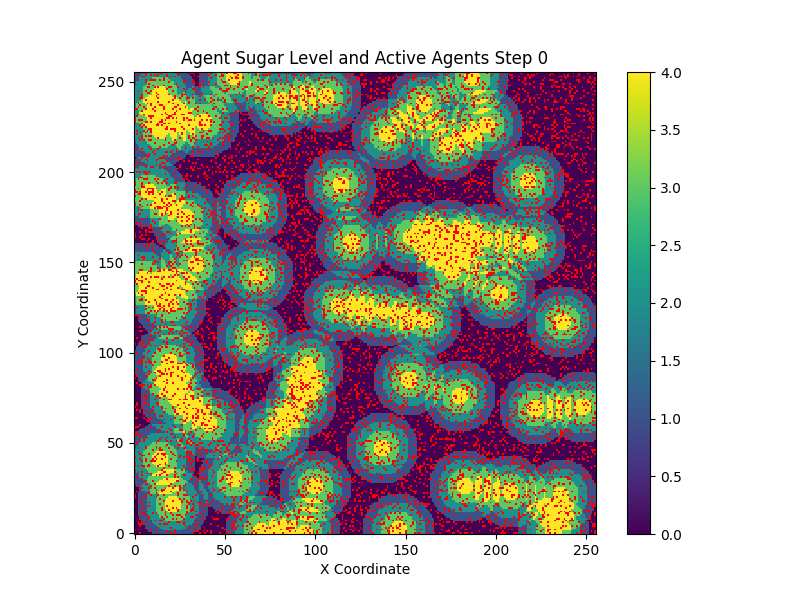

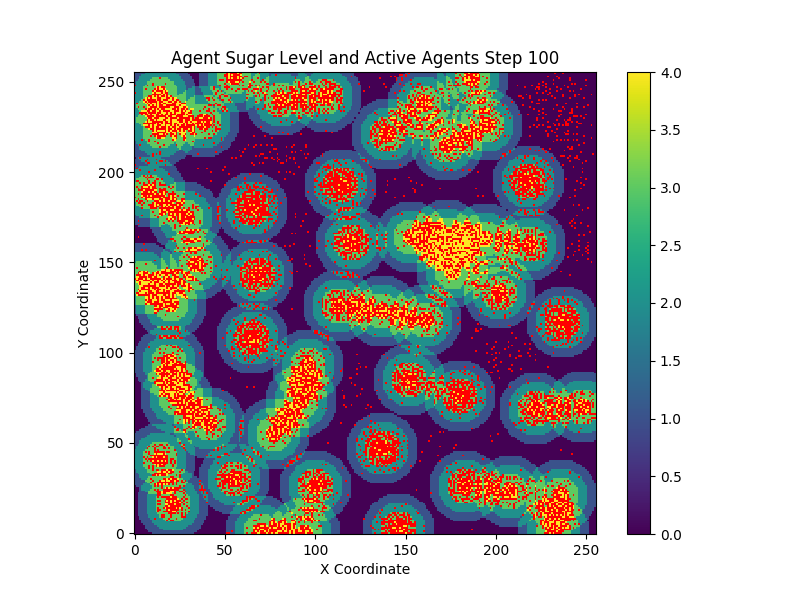

In [45]:
def visualise_model(visualisation_mode = 'display', reload=True): # valid visualisation_mode inputs are 'display', 'plot', 'animate'
    # reload data if reload is true
    if reload:
        sugarscape_visualiser.load_data(SIMULATION_STEPS)

    # select which visualisation mode
    if visualisation_mode == 'plot':
        sugarscape_visualiser.plot_state(0)
        sugarscape_visualiser.plot_state(SIMULATION_STEPS)
    elif visualisation_mode == 'animate':
        sugarscape_visualiser.animate_states(SIMULATION_STEPS)
    elif visualisation_mode == 'display':
        sugarscape_visualiser.display_states(SIMULATION_STEPS)

# visualise the simulation
visualise_model(visualisation_mode = 'plot')

The simulation should progress by allowing each agent to move to a favourable position. As there is no behaviour yet specified for migration and growback the Sugarscape agents will not change their sugar wealth and the environmental sugar will remain constant. The behaviour observed should show some migration of agents to higher concentrations of sugar. E.g. Where a Sugarscape agent has an opportunity to pass a boundary of increased environmental sugar level it will do so. As such the sugar peaks will become increasingly populated by agents which will increase to competition of movement.

# Tutorial Exercise 1

## 1.1 Define the Behaviour of the Metabolise Function

For our first tutorial exercise we will complete the behaviour of the metabolise function in the cell below.

1. Create a local variable for agents sugar level, environment sugar level, the metabolism and the agents status. Get these values from the corresponding agent variables `sugar_level`, `env_sugar_level`, `metabolism` and `status` respectively.
2. Perform a check to see if the agent status is either `"agent_status_occupied"`  and if so perform the following tasks
    * 2.1. Check the environment sugar level. If it is greater than zero then the agent should consume the sugar at the location. *Hint: increase the local variable for agent sugar level and set the local variable for the environment sugar level to 0.*
    * 2.2. Metabolise sugar. *Hint: reduce the local variable for agent sugar level by the metabolism value*.
    * 2.3 If the agents sugar level is below zero then the agent should die and the agents state variables should be updated to reflect this. *Hint: the status should be set to `"agent_status_unoccupied"`, the `agent_id` should be set to `-1` and the metabolism value set to `0`.
3. The agent sugar level and environment sugar level should be set from the local variables.

Use the cell below to modify the metabolise function, run the simulation and visualise the output. You can simply re-run this cell if you make changes. If you produce an invalid agent function then the output will produce a runtime error with the runtime compilation error reported in the output. 

*Note: Any compilation errors will be from the transpiled C++ rather than the pure Python but it will give a fairly clear indication of which part of the agent function is incorrect*.

*Note 2: Running this cell will be slow as the agent function must be runtime compiled. Each time an agent function changes the compilation will need to take place again. If the agent functions are not changed then they will be cached and you will notice an improvement in the runtime.* 

In [ ]:
@pyflamegpu.agent_function
def metabolise(message_in: pyflamegpu.MessageNone, message_out: pyflamegpu.MessageNone):

    # TODO: Add your code here
    
    return pyflamegpu.ALIVE


execute_simulation() 
visualise_model()

If you have completed the exercise correctly you should observe the agents migrating as they did before, however, now they will consume the sugar within the environment until it has run out. Once they have consumed all the sugar the agents will begin to die.

### Exercise 1.1 Solution

The code below provides the solution for exercise 1.1.

In [ ]:
@pyflamegpu.agent_function
def metabolise(message_in: pyflamegpu.MessageNone, message_out: pyflamegpu.MessageNone):
    agent_sugar_level = pyflamegpu.getVariableInt("sugar_level")
    env_sugar_level = pyflamegpu.getVariableInt("env_sugar_level")
    status = pyflamegpu.getVariableInt("status")
    metabolism = pyflamegpu.getVariableInt("metabolism")

    # metabolise if occupied
    if (status == pyflamegpu.environment.getPropertyInt("agent_status_occupied")):
        
        # store any sugar present in the cell
        if (env_sugar_level > 0) :
            agent_sugar_level += env_sugar_level
            # Occupied cells are marked as -1 sugar.
            env_sugar_level = 0;

        # metabolise
        agent_sugar_level -= metabolism

        # check if agent dies
        if (agent_sugar_level <= 0) :
            status = pyflamegpu.environment.getPropertyInt("agent_status_unoccupied");
            # env_sugar_level = 0;
            pyflamegpu.setVariableInt("agent_id", -1);
            pyflamegpu.setVariableInt("metabolism", 0);
            pyflamegpu.setVariableInt("status", status);

    pyflamegpu.setVariableInt("sugar_level", agent_sugar_level);
    pyflamegpu.setVariableInt("env_sugar_level", env_sugar_level);

    return pyflamegpu.ALIVE

# run the model and visualise the output
execute_simulation() 
visualise_model()


## 1.2 Define the Behaviour of the Growback Function

In order to extend our model we will now implement the behaviour of the `growback` function for sugar within the environment. In the cell below extend the `growback` function by adding the following behaviour.

1. Create a local variable for environment sugar level, the environment maximum sugar level and the agents status. Get these values from the corresponding agent variables `env_sugar_level`, `env_max_sugar_level` and `status` respectively.
2. Perform a check to see if the agent status is either `"agent_status_unoccupied"`  and if so perform the following tasks
    * 2.1. Increase the local variable for the environment sugar level by the sugar growback rate. *Hint: The growback rate is an environment property called `sugar_growback_rate`*
    * 2.2 If the local variable for the environment sugar level exceeds the maximum value permitted for this cell then limit it to the maximum value.
3. The agents environment sugar level should be set from the local variable.

You can re-run this cell if you make changes. If you produce an invalid agent function then the output will produce a runtime error with the runtime compilation error reported in the output. 


In [ ]:
@pyflamegpu.agent_function
def growback(message_in: pyflamegpu.MessageNone, message_out: pyflamegpu.MessageNone):

    # TODO: Add your code here

    return pyflamegpu.ALIVE

# run the model and visualise the output
execute_simulation() 
visualise_model()

If you have completed the exercise correctly then the environment should grown back and the agents should migrate and consume sugar. Over time this will each an equilibrium where agents continue to consume sugar as it grows back within the environment.

### Exercise 1.2 Solution

The code below provides the solution for exercise 1.1.

In [ ]:
@pyflamegpu.agent_function
def growback(message_in: pyflamegpu.MessageNone, message_out: pyflamegpu.MessageNone):
    env_sugar_level = pyflamegpu.getVariableInt("env_sugar_level");
    status = pyflamegpu.getVariableInt("status");
    env_max_sugar_level = pyflamegpu.getVariableInt("env_max_sugar_level");
    
    # growback if unoccupied
    if (status == pyflamegpu.environment.getPropertyInt("agent_status_unoccupied")) :
        env_sugar_level += pyflamegpu.environment.getPropertyInt("sugar_growback_rate")
        if (env_sugar_level > env_max_sugar_level) :
            env_sugar_level = env_max_sugar_level
            

    pyflamegpu.setVariableInt("env_sugar_level", env_sugar_level);

    return pyflamegpu.ALIVE

# run the model and visualise the output
execute_simulation() 
visualise_model()

# Tutorial Exercise 2

You now have a complete Sugarscape model which demonstrates migration with continuous growback. From here there are many options to extend the model which are left as a user exercise. For example you could (with indicator of difficulty);

1) Modify the model parameters to observe the effects on the emergent behaviour of the population. (Easy)
2) Add [logging](https://docs.flamegpu.com/guide/visualisation/index.html) to the model to create plots of the Sugarscape agent population. (Med)
3) Create an [ensemble of simulations](https://docs.flamegpu.com/guide/running-multiple-simulations/index.html) and plot (rather than visualise) how varying a model paramter impacts the emergent behaviour. E.g. population size or sugar wealth. (Hard)
4) Add reproduction behaviour to the model. This can be achieved by;
    * Adding a gender and age (in iterations) to the agents
    * Creating a reproduction rule where female agents within some age limit will select the highest priority male to create an offspring which will be born with half the sugar from each parent. If there is a collision for the birth location the highest priority female wins. (Hard)
5) Add complex reproduction behaviour to the model where a submodel is used to ensure that females can select a free cell for offspring in the case of competition. (Very Hard)

Alternatively you could add other forms of behaviour such as disease propagation (i.e. A simple SIR type model) to the mobile agents.